# Fourier transform methods


In this notebook I want to show how the characteristic function can be used to price derivatives.    
Sometimes it will be convenient to use this method, because for some stochastic processes the probability density function is not always known, or can have a quite complicated formula, while the characteristic function is frequently available.    
For Lévy processes, in particular, the characteristic function is always known, and is given by the Lévy-Kintchkine representation (see **A3**).    

I will present some examples in which I'm going to price European call options using the Normal, the Merton and the Variance Gamma characteristic functions.  
For a complete presentation of Fourier methods, I suggest to have a look at [1].

## Contents
   - [Inversion theorem](#sec1)
   - [Numerical inversion](#sec2)
   - [Option pricing](#sec3)
   - [Lewis method](#sec4)
   - [Fast Fourier Transform](#sec5)

Let us recall the definition of the **characteristic function** $\phi_{X}(\cdot)$ of the random variable $X$:

\begin{align}
\phi_{X}(u) &= \mathbb{E} \bigl[ e^{iuX} \bigr] \nonumber \\
            &= \int_{\mathbb{R}} e^{iux} f_X(x) dx.
\end{align}

where $f_X$ is the density of $X$.    
The characteristic function is nothing but the **Fourier transform** of $f_X$.    
Let us review some properties:
-  $\phi_{X}(u)$ always exists. This is because $\bigl| \int_{\mathbb{R}} e^{iux} f_X(x) dx \bigr| \leq \int_{\mathbb{R}} | e^{iux} f_X(x)| dx < \infty$.  Recall that $|e^{iux}|=1$ and $\int_{\mathbb{R}} |f_X(x)| dx = 1$.
-  $\phi_{X}(0) = 1$.
-  $\phi_{X}(u)^{*} = \phi_{X}(-u)$, where $*$ means complex conjugate.

The density function can be obtained by taking the **inverse Fourier transform**:

$$ f_X(x) = \frac{1}{2\pi} \int_{\mathbb{R}} e^{-iux} \phi_X(u) du $$

<a id='sec1'></a>
## Inversion theorem

Let us consider the following representation of the cumulative density function:

\begin{align*}
F_X(x) &= \mathbb{P}(X<x) = \int_{-\infty}^x f_X(t) dt \\
       &= \frac{1}{2} - \frac{1}{2\pi} \int_{\mathbb{R}} \frac{e^{-iux} \phi_X(u)}{iu} du 
\end{align*}

By taking the derivative of $F_X$, you can check that it gives the expression for $f_X$.

But.... How to obtain this formula?

I think this is a quite interesting topic, so... I present the proof.    (for more information have a look at [2])

#### Proof - step 1

Let us consider the sign function [wiki](https://en.wikipedia.org/wiki/Sign_function),
$$ sgn(x) =  \begin{cases}
 -1 &=  x<0 \\
 0  &=  x=0 \\
 1  &=  x>0.
\end{cases} $$

The step function has Fourier transform equal to 
$$\mathcal{F}[sgn(x)] = \frac{2}{iu}$$ 
(intended as the [Cauchy principal value](https://en.wikipedia.org/wiki/Cauchy_principal_value) ).

In order to prove it, let us consider the function

$$ g_a(x) =  \begin{cases}
 -e^{ax} &=  x<0 \\
 0  &=  x=0 \\
 e^{-ax}  &=  x>0.
\end{cases} $$

with $a>0$. When $a \to 0$, the function $g_a(x)$ converges to $sgn(x)$.

The Fourier transform of $g_a$ can be computed easily by splitting the integral in two (if you are lazy, have a look at the table [here](https://en.wikipedia.org/wiki/Fourier_transform#Square-integrable_functions,_one-dimensional)):

\begin{align*}
\mathcal{F}[g_a(x)] &= \frac{1}{a+iu} - \frac{1}{a-iu} \\
                  &= - \frac{2iu}{a^2 + u^2}  
\end{align*}

We can send $a\to 0$ and obtain the relation we were looking for.


#### Proof - step 2

The convolution of the density function $f_X$ with the sign function is given by:

\begin{align*}
(f_X * sgn)(x) &= \int_{-\infty}^{\infty} f_X(x+t) \, sgn(t) \, dt \\
               &= \int_{-\infty}^{0} f_X(x+t) \, (-1) dt + \int_{0}^{\infty} f_X(x+t)\, (1) dt \\
               &= - F_X(x) + 1 - F_X(x) \\
               &= 1 - 2 F_X(x)
\end{align*}


#### Proof - step 3

By the convolution theorem [wiki](https://en.wikipedia.org/wiki/Convolution_theorem) we know that:

$$ (f_X * sgn) = \mathcal{F}^{-1} \, \biggl[ \mathcal{F}[f_X] \cdot \mathcal{F}[sgn] \biggr] $$

Therefore we have that 

\begin{align*}
  (f_X * sgn)(x) &= \frac{1}{2\pi} \int_{\mathbb{R}} e^{-iux} \phi_X(u) \cdot \frac{2}{iu} \, du
\end{align*}

#### Proof - conclusion

We can put together the steps 2 and 3:

$$ 1 - 2 F_X(x) = \frac{1}{2\pi} \int_{\mathbb{R}} e^{-iux} \phi_X(u) \cdot \frac{2}{iu} \, du $$

Rearranging the terms, we can conclude the proof:

$$ F_X(x) = \frac{1}{2} - \frac{1}{2\pi} \int_{\mathbb{R}} e^{-iux} \phi_X(u) \cdot \frac{1}{iu} \, du $$

### Gil Pelaez formulas

Recall that for a complex number z,

$$ Re[z] = \frac{z+z^*}{2}  \quad \quad Im[z] = \frac{z-z^*}{i2} $$

Starting from the inversion formula, **Gil Pelaez** [5] obtained the following expression:

\begin{align*}
  F_X(x) &= \frac{1}{2} - \frac{1}{2\pi} \int_{\mathbb{R}} e^{-iux} \phi_X(u) \cdot \frac{1}{iu} \, du \\
         &= \frac{1}{2} - \biggl( \frac{1}{2\pi} \int_{-\infty}^0 e^{-iux} \phi_X(u) \frac{1}{iu} \, du
              + \frac{1}{2\pi} \int_0^{\infty} e^{-iux} \phi_X(u) \frac{1}{iu} \, du \biggr) \\
         &= \frac{1}{2} - \frac{1}{2\pi} \int_0^{\infty} \biggl(-e^{iux} \phi_X(-u) + e^{-iux} \phi_X(u) \biggr) \frac{1}{iu} \, du \\
         &= \frac{1}{2} - \frac{1}{\pi} \int_0^{\infty} \frac{Im[ e^{-iux} \phi_X(u) ]}{u} du
\end{align*}

This formula can also be written as:

$$ F_X(x) = \frac{1}{2} - \frac{1}{\pi} \int_0^{\infty} Re\biggl[ \frac{ e^{-iux} \phi_X(u)}{iu} \biggr] du $$

We obtain the expression for the density by taking the derivative:

$$ f_X(x) = \frac{1}{\pi} \int_0^{\infty} Re\biggl[ e^{-iux} \phi_X(u) \biggr] du $$

### Pricing formula by Fourier inversion

In the notebook **1.1** we found that the pricing formula for a call option with stike K and maturity T is: 

$$  C(t, S_t,K,T) = S_t \tilde{\mathbb{Q}} ( S_T > K ) - e^{-r(T-t)} K \, \mathbb{Q}( S_T >K ) $$

where $\tilde{\mathbb{Q}}$ is the probability under the stock numeraire and $\mathbb{Q}$ is the probability under the money market numeraire.

#### This formula is model independent! 

When the stock follows a geometric Brownian motion, this formula corresponds to the Black-Scholes formula.

Now let us express $\tilde{\mathbb{Q}}$ and $\mathbb{Q}$ in terms of the characteristic function using the Gil Pelaez formula.    
Let us call $k = \log \frac{K}{S_t}$ and $S_T = S_t e^{X_T}$
- For $\mathbb{Q}$ we can write: 

\begin{align*}
\mathbb{Q}(S_T >K) &= 1 - \mathbb{Q}(S_T <K) = 1 - \mathbb{Q}(X_T < k) \\
                   &= \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty} Re\biggl[ \frac{ e^{-iuk} \phi_X(u)}{iu} \biggr] du
\end{align*}

- In the same way, for $\tilde{\mathbb{Q}}$, we can write: 

\begin{align*}
\tilde{\mathbb{Q}}(S_T >K) &= \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty} Re\biggl[ \frac{ e^{-iuk} \tilde{\phi}_X(u)}{iu} \biggr] du \\
                          &= \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty} Re\biggl[ \frac{ e^{-iuk} \phi_X(u-i)}{iu \, \phi_X(-i)} \biggr] du  
\end{align*}

where

\begin{align*}
 \tilde{\phi}_X(u) &= \mathbb{E}^{\tilde{\mathbb{Q}}} \bigl[ e^{iuX_T} \bigr] = \mathbb{E}^{\mathbb{Q}} \biggl[ \frac{d\tilde{\mathbb{Q}}}{d \mathbb{Q}} e^{iuX_T} \biggr] \\  
                   &= \mathbb{E}^{\mathbb{Q}} \biggl[ \frac{S_t e^{X_T}}{S_t \mathbb{E}^\mathbb{Q}[e^{X_T}]} e^{iuX_T} \biggr] \\
                   &= \mathbb{E}^{\mathbb{Q}} \biggl[ \frac{e^{(iu+1)X_T}}{\phi_X(-i)} \biggr] \\
                   &= \frac{\phi_X(u-i)}{\phi_X(-i)}
\end{align*}


(see the notebook **1.1** for a discussion about this change of measure).

<a id='sec2'></a>
## Numerical inversion


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.integrate import quad
from functools import partial
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d

from FMNM.BS_pricer import BS_pricer
from FMNM.Parameters import Option_param
from FMNM.Processes import Merton_process
from FMNM.Merton_pricer import Merton_pricer
from FMNM.Processes import VG_process
from FMNM.VG_pricer import VG_pricer

In [2]:
def cf_normal(u, mu=1, sig=2):
    return np.exp(1j * u * mu - 0.5 * u**2 * sig**2)

In [3]:
def cf_gamma(u, a=1, b=2):
    return (1 - b * u * 1j) ** (-a)

In [4]:
def cf_poisson(u, lam=1):
    return np.exp(lam * (np.exp(1j * u) - 1))

Let us consider the following characteristic functions:

##### Normal:
$\mathcal{N}(\mu,\sigma^2)$, $\sigma>0$.
$$ \phi_N(u) = e^{i\mu u - \frac{1}{2}\sigma^2 u^2} $$
##### Gamma (shape-scale parameterization) 
$\Gamma(a,b)$, $a,b >0$.
$$ \phi_G(u) = (1-ibu)^{-a} $$
##### Poisson
$Po(\lambda)$, $\lambda>0$.
$$ \phi_P(u) = e^{\lambda (e^{iu}-1)} $$

I want to check if the Gil Pelaez formula works:

In [5]:
# Gil Pelaez formula for the density
# right_lim is the right extreme of integration
# cf is the characteristic function
def Gil_Pelaez_pdf(x, cf, right_lim):
    integrand = lambda u: np.real(np.exp(-u * x * 1j) * cf(u))
    return 1 / np.pi * quad(integrand, 1e-15, right_lim)[0]

### Normal

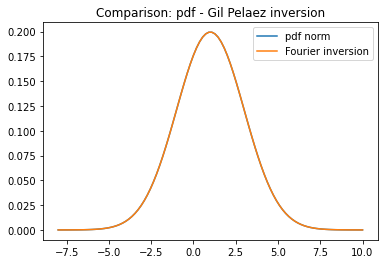

In [6]:
x = np.linspace(-8, 10, 100)
plt.plot(x, ss.norm.pdf(x, loc=1, scale=2), label="pdf norm")
plt.plot(x, [Gil_Pelaez_pdf(i, cf_normal, np.inf) for i in x], label="Fourier inversion")
plt.title("Comparison: pdf - Gil Pelaez inversion")
plt.legend()
plt.show()

### Gamma

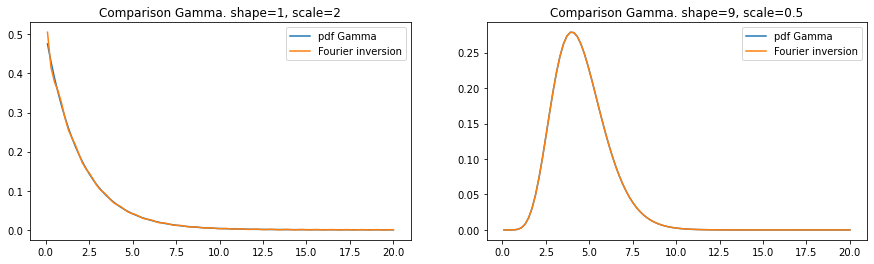

In [7]:
xx = np.linspace(0.1, 20, 100)
a = 1  # shape parameter
b = 2  # scale parameter
c = 9  # shape parameter
d = 0.5  # scale parameter
lim_ab = 24
lim_cd = np.inf
cf_gamma_ab = partial(cf_gamma, a=a, b=b)  # function binding
cf_gamma_cd = partial(cf_gamma, a=c, b=d)  # function binding

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(xx, ss.gamma.pdf(xx, a, scale=b), label="pdf Gamma")
ax1.plot(xx, [Gil_Pelaez_pdf(i, cf_gamma_ab, lim_ab) for i in xx], label="Fourier inversion")
ax1.set_title("Comparison Gamma. shape=1, scale=2")
ax1.legend()
ax2.plot(xx, ss.gamma.pdf(xx, c, scale=d), label="pdf Gamma")
ax2.plot(xx, [Gil_Pelaez_pdf(i, cf_gamma_cd, lim_cd) for i in xx], label="Fourier inversion")
ax2.set_title("Comparison Gamma. shape=9, scale=0.5")
ax2.legend()
plt.show()

#### Comments:

If you try to increase the value of `lim_ab = 24`, you will see that python will raise:     
`IntegrationWarning: The maximum number of subdivisions (50) has been achieved.`

When we solve this kind of problems we have to be careful, and analyze them case by case.

For $c=9$ and $d=0.5$, we could set `lim_cd = np.inf` because the integrand has a good behavior.    
But for $a=1$ and $b=2$ the integrand is not so nice. There are many oscillations (originated by the term $e^{-iux}$) that create the problem.

Let's have a look at the plot of the integrands: (at the point x=3)

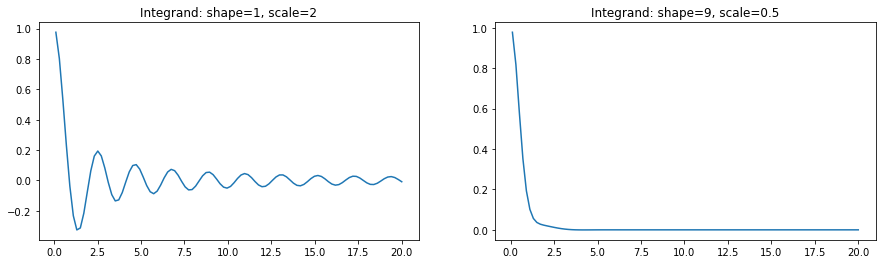

In [8]:
u = np.linspace(0.1, 20, 100)
x = 3
f = lambda u: np.real(np.exp(-u * x * 1j) * cf_gamma_ab(u))  # integrand
g = lambda u: np.real(np.exp(-u * x * 1j) * cf_gamma_cd(u))

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(u, f(u))
ax1.set_title("Integrand: shape=1, scale=2")
ax2.plot(u, g(u))
ax2.set_title("Integrand: shape=9, scale=0.5")
plt.show()

### Poisson

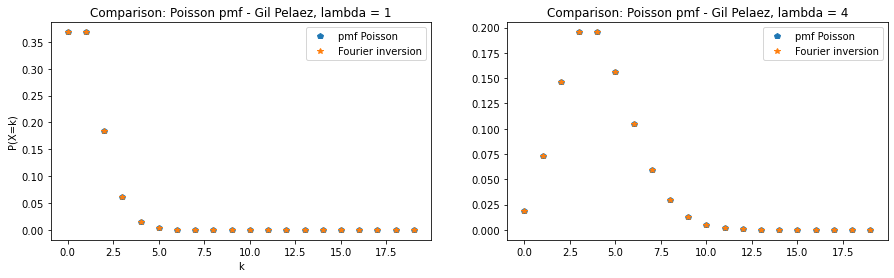

In [9]:
k = np.array(range(20))
lam = 4
cf_poisson4 = partial(cf_poisson, lam=lam)  # function binding to lam=4

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(k, ss.poisson.pmf(k, 1), linestyle="None", marker="p", label="pmf Poisson")  # with lam=1
ax1.plot(
    k, [Gil_Pelaez_pdf(i, cf_poisson, np.pi) for i in k], linestyle="None", marker="*", label="Fourier inversion"
)  # lam=1 by default
ax1.set_xlabel("k")
ax1.set_ylabel("P(X=k)")
ax1.set_title("Comparison: Poisson pmf - Gil Pelaez, lambda = 1")
ax1.legend()
ax2.plot(k, ss.poisson.pmf(k, lam), linestyle="None", marker="p", label="pmf Poisson")
ax2.plot(k, [Gil_Pelaez_pdf(i, cf_poisson4, np.pi) for i in k], linestyle="None", marker="*", label="Fourier inversion")
ax2.set_title("Comparison: Poisson pmf - Gil Pelaez, lambda = 4")
ax2.legend()
plt.show()

##### Comments:

In this case, we considered only the integration in the region $[0,\pi]$.

As you can see in the plots below, the integrand is an even periodic function. Therefore, if we had integrated on $[0,\infty]$ the integral would have been infinite.

The two plots below consider the characteristic function with $\lambda=1$.     
The integrands inside the `Gil_Pelaez_pdf` function are functions of $u$ with fixed values of $x$. For this exaple I chose x=1 and x=10 ($x$ corresponds to $k$ in the plots above).     
The characteristic function of a Poisson random variable does not have a damping factor. It is a pure periodic function. For this reason it is helpful to define it only on $[-\pi,\pi]$.    
The integrand of the Gil Pelaez function simply inherits these features.

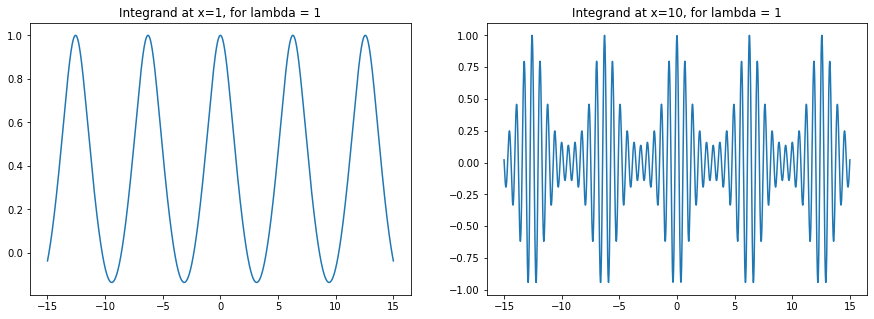

In [10]:
X1 = 1
X2 = 10
y = np.linspace(0.0 - 15, 15, 2000)
ff = lambda u: np.real(np.exp(-u * X1 * 1j) * cf_poisson(u))  # integrand
gg = lambda u: np.real(np.exp(-u * X2 * 1j) * cf_poisson(u))  # integrand

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(y, ff(y))
ax1.set_title("Integrand at x=1, for lambda = 1")
ax2.plot(y, gg(y))
ax2.set_title("Integrand at x=10, for lambda = 1")
plt.show()

<a id='sec3'></a>
## Option pricing

Let us apply the pricing formula introduced above using the following processes:
- Geometric Brownian motion
- Merton process
- Variance Gamma process

These processes will be described better in the next notebooks. If you are not familiar with these concepts, have a look at the Appendix **A3**. Otherwise you can skip this part, for now. And come back again after having read the relevant notebooks.

First, I have to implement $\mathbb{Q}$ and $\tilde{\mathbb{Q}}$:

In [11]:
def Q1(k, cf, right_lim):
    integrand = lambda u: np.real((np.exp(-u * k * 1j) / (u * 1j)) * cf(u - 1j) / cf(-1j))
    return 1 / 2 + 1 / np.pi * quad(integrand, 1e-15, right_lim, limit=1000)[0]

In [12]:
def Q2(k, cf, right_lim):
    integrand = lambda u: np.real(np.exp(-u * k * 1j) / (u * 1j) * cf(u))
    return 1 / 2 + 1 / np.pi * quad(integrand, 1e-15, right_lim, limit=1000)[0]

In the following, I present European call option values, with the following parameters:

In [13]:
S0 = 100.0  # spot stock price
K = 100.0  # strike
T = 1  # maturity
k = np.log(K / S0)  # log moneyness

### Geometric Brownian motion

In [14]:
r = 0.1  # risk free rate
sig = 0.2  # volatility

In [15]:
cf_GBM = partial(cf_normal, mu=(r - 0.5 * sig**2) * T, sig=sig * np.sqrt(T))  # function binding
call_BS = S0 * Q1(k, cf_GBM, np.inf) - K * np.exp(-r * T) * Q2(k, cf_GBM, np.inf)  # pricing function

print("Fourier inversion call: ", call_BS)
print("Closed formula call: ", BS_pricer.BlackScholes("call", S0, K, T, r, sig))

Fourier inversion call:  13.2696765846609
Closed formula call:  13.269676584660893


### Merton process

In [16]:
# characteristic function of the Merton process at time t
def cf_mert(u, t=1, mu=1, sig=2, lam=0.8, muJ=0, sigJ=0.5):
    return np.exp(
        t * (1j * u * mu - 0.5 * u**2 * sig**2 + lam * (np.exp(1j * u * muJ - 0.5 * u**2 * sigJ**2) - 1))
    )

In [17]:
r = 0.1  # risk free rate
sig = 0.2  # diffusion coefficient
lam = 0.8  # jump activity
muJ = 0  # jump mean size
sigJ = 0.5  # jump std deviation
m = lam * (np.exp(muJ + (sigJ**2) / 2) - 1)  # martingale correction

# Creates the pricer objects
opt_param = Option_param(S0=S0, K=K, T=T, exercise="European", payoff="call")
Merton_param = Merton_process(r=r, sig=sig, lam=lam, muJ=muJ, sigJ=sigJ)
Merton = Merton_pricer(opt_param, Merton_param)

In [18]:
# function binding
cf_Mert = partial(cf_mert, t=T, mu=(r - 0.5 * sig**2 - m), sig=sig, lam=lam, muJ=muJ, sigJ=sigJ)
# call price
call_Mert = S0 * Q1(k, cf_Mert, np.inf) - K * np.exp(-r * T) * Q2(k, cf_Mert, np.inf)  # pricing function

print("Fourier inversion call: ", call_Mert)
print("Closed formula call: ", Merton.closed_formula())

Fourier inversion call:  22.0163676219057
Closed formula call:  22.016367621905697


### Variance Gamma

In [19]:
# characteristic function of the VG process at time t, with an additional drift mu
def cf_VG(u, t=1, mu=0, theta=-0.1, sigma=0.2, kappa=0.1):
    return np.exp(t * (1j * mu * u - np.log(1 - 1j * theta * kappa * u + 0.5 * kappa * sigma**2 * u**2) / kappa))

In [20]:
# Creates the object with the parameters of the process
VG_param = VG_process(r=0.1, sigma=0.2, theta=-0.1, kappa=0.1)
# Creates the VG process
VG = VG_pricer(opt_param, VG_param)

theta = -0.1
sigma = 0.2
kappa = 0.1  # VG parameters
w = -np.log(1 - theta * kappa - kappa / 2 * sigma**2) / kappa  # martingale correction w

In [21]:
# function binding
cf_VG_b = partial(cf_VG, t=T, mu=r - w, theta=theta, sigma=sigma, kappa=kappa)
# call price
call_VG = S0 * Q1(k, cf_VG_b, np.inf) - K * np.exp(-r * T) * Q2(k, cf_VG_b, np.inf)  # pricing function

print("Fourier inversion call: ", call_VG.round(6))
print("Monte Carlo call: {0[0]:.6f} with standard error: {1[0]:.6f}".format(*VG.MC(N=50000000, Err=True)))

Fourier inversion call:  13.314022
Monte Carlo call: 13.316149 with standard error: 0.002253


The closed formula for the VG price is also available, but it is not very reliable (it has a negative bias).  See also the comments in the notebook **3.2**.       
For this reason I prefer to compare the Fourier inversion price with the Monte Carlo price!

#### Warning: infinite oscillatory integrals!

The naive implementation of $\mathbb{Q}$ and $\tilde{\mathbb{Q}}$ in the functions `Q1` and `Q2` uses the scipy method `quad` which is not very appropriate for infinite oscillatory integrals.

A possible solution could be to set the parameters `weight` and `wvar` in [quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html) appropriately, or use a more advanced algorithm. However, these integrals must be treated on a case-by-case basis.       
For more information about oscillatory integrals have a look at this
[link](https://scicomp.stackexchange.com/questions/58/whats-the-state-of-the-art-in-highly-oscillatory-integral-computation).

#### Example:
As for the pricing problem we are considering, the naive approach above works quite well for a large time to maturity.      
For a short time to maturity, OTM and ITM options have problems.   
In the following plot we can see that the integrand function has different shapes for different moneyness.     
In this example, the `quad` method produces a negative price for the call with K=120.

Strike= 105.0
Fourier inversion Black-Scholes call:  0.005750947197630807
BS Closed formula call:  0.005750947197631251
Strike= 120.0
Fourier inversion Black-Scholes call:  -1.103565016036534e-15
BS Closed formula call:  1.4557223869346492e-20


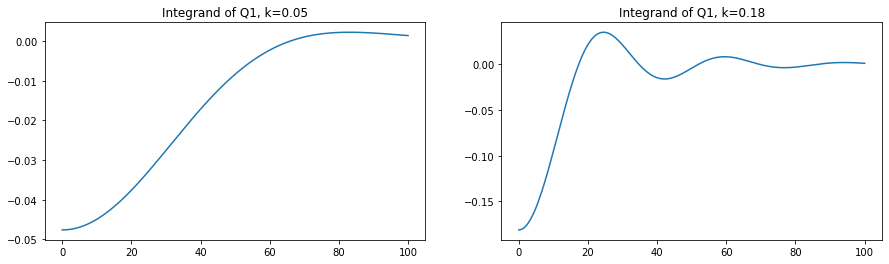

In [22]:
S0 = 100.0
K1 = 105.0
K2 = 120.0
T_1 = 0.01
k1 = np.log(K1 / S0)
k2 = np.log(K2 / S0)  # two different moneyness
cf_GBM_1 = partial(cf_normal, mu=(r - 0.5 * sig**2) * T_1, sig=sig * np.sqrt(T_1))
call1 = S0 * Q1(k1, cf_GBM_1, np.inf) - K1 * np.exp(-r * T_1) * Q2(k1, cf_GBM_1, np.inf)  # pricing function
print("Strike=", K1)
print("Fourier inversion Black-Scholes call: ", call1)
print("BS Closed formula call: ", BS_pricer.BlackScholes("call", S0, K1, T_1, r, sig))
call2 = S0 * Q1(k2, cf_GBM_1, np.inf) - K2 * np.exp(-r * T_1) * Q2(k2, cf_GBM_1, np.inf)  # pricing function
print("Strike=", K2)
print("Fourier inversion Black-Scholes call: ", call2)
print("BS Closed formula call: ", BS_pricer.BlackScholes("call", S0, K2, T_1, r, sig))

u = np.linspace(1e-15, 100, 200)
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(u, np.real((np.exp(-u * k1 * 1j) / (u * 1j)) * cf_GBM_1(u - 1j) / cf_GBM_1(-1j)))
ax2.plot(u, np.real((np.exp(-u * k2 * 1j) / (u * 1j)) * cf_GBM_1(u - 1j) / cf_GBM_1(-1j)))
ax1.set_title("Integrand of Q1, k={0:0.2f}".format(k1))
ax2.set_title("Integrand of Q1, k={0:0.2f}".format(k2))
plt.show()

<a id='sec4'></a>
# Lewis method

Fourier inversion methods in option pricing allow the use of semi-closed valuation formulas for European options whenever the characteristic function of the log-price is known.
There is a large body of literature dealing with Fourier-based pricing methods. Among the most important there are the methods of Carr and Madan (1999) [3] and Lewis (2001) [4].

The Gil-Pelaez approach described above, consists in expressing the "in the money" risk neutral probabilities as the integral of an expression containing the characteristic function of the log-process.    
Here I present the method of Lewis which instead provides an integral expression for the option price itself.
The paper of Lewis can be found here http://optioncity.net/pubs/ExpLevy.pdf. 

**Tecnical comment** (irrelevant to the understanding of the derivation):     
The functional space $L^2$ is not a subset of $L^1$ (see [Lp space](https://en.wikipedia.org/wiki/Lp_space)), and the definition of the Fourier transform is therefore not directly applicable to every $L^2$ function. The definition does apply, however, if a function $f$ is in $L^1 \cap L^2$, and
it turns out that the $\mathcal{F}[f] \in L^2$, and $\lVert f \rVert^2 = \big \lVert \mathcal{F}[f] \big \rVert^2$ (see [Placherel and Parseval theorem](https://en.wikipedia.org/wiki/Fourier_transform#Plancherel_theorem_and_Parseval's_theorem)). 
This isometry of $L^1 \cap L^2$ into
$L^2$ can be extended to an isometry of $L^2$ onto $L^2$, and this extension defines the Fourier
transform of every function in $L^2$.


#### Derivation of Lewis formula:

The Lewis approach makes use of the [Parseval formula](https://en.wikipedia.org/wiki/Fourier_transform#Plancherel_theorem_and_Parseval's_theorem), i.e. the Fourier transform preserves the inner product.    
If we consider the log-price $X_T = \log S_T$ and $s=\log S_0$, the CALL option price is defined as 

$$
\begin{aligned}
C(S_0, K,T) &= e^{-rT} \mathbb{E}^{\mathbb{Q}}\biggl[ \big(e^{X_T} - K\big)^+ \bigg| \log S_0 = s \biggr] \\
  &= e^{-rT} \int_{\mathbb{R}} \big(e^x-K\big)^+ f_T(s+x) \,dx \\
  &= e^{-rT} \int_{\mathbb{R}} \mathcal{F}  \bigg[\big(e^x-K\big)^+ \bigg] \; \mathcal{F}\big[f_T(s+x)\big]^* \; \frac{du}{2\pi}.
\end{aligned} $$

Since the function $(e^x-K)^+$ is not integrable, the idea is to consider the *Generalized Fourier Transform* i.e. replace the real variable $u$ with a complex variable $z = u + iv$:

$$ \mathcal{F}\bigg[\big(e^x-K\big)^+ \bigg] = \int_{\log K}^{\infty} e^{ixz} \big(e^x-K\big) \, dx 
= - \frac{K^{iz+1}}{z^2-iz} $$

The integral above exists only for some $v_1 = Im[z] > 1$.      
Using the translation property and the property of the complex conjugation of the characteristic function, we can write 

$$ \mathcal{F}\big[f_T(s+x)\big]^*(z) = e^{-izs} \phi_T(-z).$$     

The pricing function becomes:

$$ \begin{aligned}
C(S_0, K,T) &= -e^{-rT} \int_{iv_1-\infty}^{iv_1+\infty} e^{-izs} \frac{K^{iz+1}}{z^2-iz} \; \phi_T(-z) \; \frac{dz}{2\pi} \\
&= -K e^{-rT} \int_{iv_1-\infty}^{iv_1+\infty} e^{-izk} \frac{1}{z^2-iz} \; \phi_T(-z) \; \frac{dz}{2\pi}. \end{aligned}$$

where we introduced the log-moneyness $k = \log S_0 - \log K$.    
At this point, Lewis uses the [Residue theorem](https://en.wikipedia.org/wiki/Residue_theorem) in order to write this expression in a different form, where the integral is on the orizontal line with imaginary level $Im[z] = v_2 \in (0,1)$.    
The integration is made on a rectangular region containing the pole at $i$.    
The integral is split on each side of the rectangle: 
$$\int_{-\infty + iv_2}^{+\infty + iv_2} + \int_{+\infty + iv_2}^{+\infty + iv_1} + \int_{+\infty + iv_1}^{-\infty + iv_1} + \int_{-\infty + iv_1}^{-\infty + iv_2} = 
\int_{-\infty + iv_2}^{+\infty + iv_2} - \int_{-\infty + iv_1}^{+\infty + iv_1} = \; 2 \pi i \, Res(i) $$

where the terms $\int_{-\infty + iv_1}^{-\infty + iv_2}$ and $\int_{+\infty + iv_2}^{+\infty + iv_1}$ are zero because the integrand is zero at $Re[z]= \pm \infty$.    
The residual is 
$$ \begin{aligned}
Res(i) &= \lim_{z\to i}\; -(z-i)\,  e^{-rT} e^{-izk} \frac{1}{z(z-i)} \; \phi_T(-z) \; \frac{K}{2\pi} \\
       &= -\frac{S_0}{2\pi i } 
\end{aligned}$$

where we recall that $\phi_T(-i) = e^{rT}$. Rearranging the terms we get the alternative expression:

$$ C(S_0, K,T) = S_0 - \frac{K e^{-rT}}{2\pi} \int_{iv_2-\infty}^{iv_2+\infty} e^{-izk} \frac{1}{z^2-iz} \; \phi_T(-z) \; dz.$$

For $v_2=\frac{1}{2}$, we can replance $z=u+\frac{i}{2}$ and obtain the final form: 

$$ C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} \int_{0}^{\infty} Re \biggl[ e^{iuk} \phi_T \bigg(u-\frac{i}{2} \bigg) \biggr] \frac{1}{u^2 + \frac{1}{4}} du. $$

In [23]:
def Lewis(K, cf):
    """Numerical integration of the Lewis expression
    K = strike
    cf = characteristic function"""
    k = np.log(S0 / K)
    integrand = lambda u: np.real(np.exp(u * k * 1j) * cf(u - 0.5j)) * 1 / (u**2 + 0.25)
    int_value = quad(integrand, 0, 2000, limit=1000)[0]
    return S0 - np.sqrt(S0 * K) * np.exp(-r * T) / np.pi * int_value

In [24]:
print("Black-Scholes: Lewis call: ", Lewis(100, cf_GBM))
print("Black-Scholes: Fourier inversion call: ", call_BS)
print()
print("Merton: Lewis call: ", Lewis(100, cf_Mert))
print("Merton: Fourier inversion call: ", call_Mert)
print()
print("Variance Gamma: Lewis call: ", Lewis(100, cf_VG_b))
print("Variance Gamma: Fourier inversion call: ", call_VG)

Black-Scholes: Lewis call:  13.269676584660886
Black-Scholes: Fourier inversion call:  13.2696765846609

Merton: Lewis call:  22.0163676219057
Merton: Fourier inversion call:  22.0163676219057

Variance Gamma: Lewis call:  13.314021941453163
Variance Gamma: Fourier inversion call:  13.314021941453447


<a id='sec5'></a>
# FFT method

Above we have numerically calculated the integral of the Lewis expression.    
However, when we want to compute the price of a large number of options with the same maturity, the previous method is no more efficient.    
A solution is to take advantage of the [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) (Fast Fourier Transform) algorithm to reduce the computational cost.

Let us recall that the *real part* of a complex number is linear, i.e. for $a,b\in \mathbb{R}$ we have $Re[a z_1 + b z_2] = a Re[z_1] + b Re[z_2]$, and the real part of an integral is the integral of the real part.    
Thanks to this property, the integral pricing formula can be written in the following form:

$$ C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} Re \biggl[ \int_{0}^{\infty} e^{iuk} \phi_T \bigg(u-\frac{i}{2} \bigg) \frac{1}{u^2 + \frac{1}{4}} du \biggr]. $$

At this point we can discretize the integral. Following [3], we use the [Simpson rule](https://en.wikipedia.org/wiki/Simpson%27s_rule).     
The domain of integration is truncated in $[A,B] = [0,B]$, and divided in $N$ steps of size $\Delta x = \frac{B}{N}$.
We have that $x_0 = 0$ and $x_n = x_0 + n \Delta x$, for $n=0,1,2,...,N$. The integral is evaluated in $N+1$ points $f(x_n) = f_n$.     
The Simpson rule is a 3 points rule that approximates the integral as:

$$ \int_{x_0}^{x_2} f(x) \, dx \approx \frac{\Delta x}{3} \big[ f_0 + 4 f_1 + f_2 \big]. $$

if we sum over the integration domain $[x_0, x_{N-1}]$ we get

$$ \int_{x_0}^{x_{N-1}} f(x) \, dx \approx \frac{\Delta x}{3} \sum_{n=0}^{N-1} w_n \, f_n. $$

with $w_n=1$ for $n=0$ and $n=N-1$, and $w_n=4$ for $n$ odd, and $w_n=2$ for $n$ even. Notice that we are not considering the last point!

Let us define a set of $N$ values $k_j \in [-b,b]$, such that $k_j = -b + j \Delta k$, for $j=0,1,2,...,N-1$. We define the step $\Delta k$ as 

$$ \Delta k := \frac{2 \pi}{B} = \frac{1}{\Delta x} \frac{2 \pi}{N} $$       

such that we can obtain the value $b=\frac{N \Delta k}{2}$.    
The integral in the pricing function is:

$$ 
\begin{aligned}
I(k_k) &= \int_{0}^{\infty} e^{ixk_j} \phi_T \bigg(x-\frac{i}{2} \bigg) \frac{1}{x^2 + \frac{1}{4}} dx 
\quad \approx \quad \frac{\Delta x}{3} \sum_{n=0}^{N-1} w_n \, e^{ik_j x_n} \phi_T \bigg( x_n-\frac{i}{2} \bigg) \frac{1}{{x_n}^2 + \frac{1}{4}} \\
&= \frac{\Delta x}{3} \sum_{n=0}^{N-1} w_n \, e^{i (-b + j \Delta k) n \Delta x} \phi_T \bigg( x_n-\frac{i}{2} \bigg) \frac{1}{{x_n}^2 + \frac{1}{4}}. \\
&= \frac{\Delta x}{3} \sum_{n=0}^{N-1} \, e^{i 2\pi j \frac{n}{N}} \; w_n e^{-i b n \Delta x} \phi_T \bigg( x_n-\frac{i}{2} \bigg) \frac{1}{{x_n}^2 + \frac{1}{4}}.
\end{aligned}$$

The [scipy function fft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html) returns the following: `y(j) = (x * exp(-2*pi*sqrt(-1)*j*np.arange(n)/n)).sum()`.     
The [scipy function ifft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.ifft.html#scipy.fftpack.ifft) returns: `y(j) = (x * exp(2*pi*sqrt(-1)*j*np.arange(n)/n)).mean()`.    
Therefore we can use `ifft` and then multiply the output by N.

In [25]:
def fft_Lewis(K, S0, cf, interp="cubic"):
    """
    K = vector of strike
    S = spot price scalar
    cf = characteristic function
    interp can be cubic or linear
    """
    N = 2**12  # FFT more efficient for N power of 2
    B = 200  # integration limit
    dx = B / N
    x = np.arange(N) * dx  # the final value B is excluded

    weight = np.arange(N)  # Simpson weights
    weight = 3 + (-1) ** (weight + 1)
    weight[0] = 1
    weight[N - 1] = 1

    dk = 2 * np.pi / B
    b = N * dk / 2
    ks = -b + dk * np.arange(N)

    integrand = np.exp(-1j * b * np.arange(N) * dx) * cf(x - 0.5j) * 1 / (x**2 + 0.25) * weight * dx / 3
    integral_value = np.real(ifft(integrand) * N)

    if interp == "linear":
        spline_lin = interp1d(ks, integral_value, kind="linear")
        prices = S0 - np.sqrt(S0 * K) * np.exp(-r * T) / np.pi * spline_lin(np.log(S0 / K))
    elif interp == "cubic":
        spline_cub = interp1d(ks, integral_value, kind="cubic")
        prices = S0 - np.sqrt(S0 * K) * np.exp(-r * T) / np.pi * spline_cub(np.log(S0 / K))
    return prices

Let us select a set of strikes:

In [26]:
KK = np.arange(10, 201, 10)
print(KK)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200]


We run the `fft_Lewis` function for the three models used in this notebook.   
After that, we compute the error (L1 norm) which is considered as the sum of absolute differences between option prices computed by closed formula and FFT.
This error is mainly due to the interpolation method used. 
One property of the FFT method is that the resulting values are on an equally spaced log-moneyness array. 
But most of the time, the desired values are not on this equidistant array, and therefore we are forced to use interpolation methods to find the intermediate values.

We can see that linear interpolation does not work very well, while cubic spline provides the desired results.

#### Black Scholes

In [27]:
prices_BS_cub = fft_Lewis(KK, S0, cf_GBM, interp="cubic")
prices_BS_lin = fft_Lewis(KK, S0, cf_GBM, interp="linear")

print("BS linear interp Error:", np.linalg.norm(prices_BS_lin - BS_pricer.BlackScholes("call", S0, KK, T, r, sig), 1))
print("BS cubic spline Error:", np.linalg.norm(prices_BS_cub - BS_pricer.BlackScholes("call", S0, KK, T, r, sig), 1))

BS linear interp Error: 0.0607495988699249
BS cubic spline Error: 1.998515423570768e-05


#### Merton

In [28]:
Merton_prices = np.zeros_like(KK, dtype=float)
for i in range(len(KK)):
    Merton.K = KK[i]
    Merton_prices[i] = Merton.closed_formula()

In [29]:
prices_M_cub = fft_Lewis(KK, S0, cf_Mert, interp="cubic")
prices_M_lin = fft_Lewis(KK, S0, cf_Mert, interp="linear")

print("Merton linear interpolation error:", np.linalg.norm(prices_M_lin - Merton_prices, 1))
print("Merton cubic spline error:", np.linalg.norm(prices_M_cub - Merton_prices, 1))

Merton linear interpolation error: 0.037010068189591294
Merton cubic spline error: 1.0136974953667277e-05


#### Variance Gamma

In [30]:
VG_prices = np.zeros_like(KK, dtype=float)
for i in range(len(KK)):
    VG.K = KK[i]
    VG_prices[i] = VG.Fourier_inversion()

In [31]:
prices_VG_cub = fft_Lewis(KK, S0, cf_VG_b, interp="cubic")

In [32]:
print("VG cubic spline error:", np.linalg.norm(prices_VG_cub - VG_prices, 1))

VG cubic spline error: 2.3181008812489523e-05


### Performances:

When we want to price several options with same maturity (let's say, more than 10) the FFT method is the best.

In [33]:
%%timeit
VG_prices = np.zeros_like(KK, dtype=float)
for i in range(len(KK)):
    VG.K = KK[i]
    VG_prices[i] = VG.Fourier_inversion()

200 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%%timeit
prices_VG_cub = fft_Lewis(KK, S0, cf_VG_b, interp="cubic")

3.51 ms ± 30 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## References

[1] Martin Schmelze (2010), Option Pricing Formulae using Fourier Transform: Theory and Application. 

[2] N.G. Shephard (1991), "From characteristic function to distribution function, a simple framework for the theory", Econometric Theory, 7, 519-529.

[3] Carr, P. and D. Madan (1999). "Option valuation using the fast Fourier transform",
Journal of Computational Finance 2(4), 61–73.

[4] Lewis, A. (2001) "A Simple Option Formula for General Jump-Diffusion and other Exponential Lévy Processes", Envision Financial Systems and OptionCity.net, California.

[5] Gil-Pelaez, J. (1951) "Note on the inversion theorem", Biometrika 38(3–4), 481–482.